# Project for SYSC5001

### Simulation of a manufacturing plant

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from random import expovariate, weibullvariate, randint

## Creating the workstation variables and methods 
#### This stores the variables for each workstation,as well, the methods to start and finish the activities

In [140]:
class workstation:
    def __init__(self,param,iteration): #---------------------Variables 
        self.stat = 0         #Flag for worspace busy = 1, iddle = 0
        self.bufferC1 = 0     #
        self.bufferC2 = 0     #
        self.bufferC3 = 0     #
        self.work_time = 1    #Stores the total working time
        self.start_time = 0   #Store the starting time in order to compute the working time
        self.Production = 0   #Stores the total amount of Production
        self.SS_Production = 0 #Stores the total amount of Components Inspected at Steady-state
        self.parameters = param #Stores the parameters for random variable function
        self.efficiency = ['']*iteration
        self.Prod_rate = ['']*iteration
    def start_ws(self, W,clock):
        #get_random time
        b,a,c = self.parameters
        if a > 1:
            time = c*weibullvariate(a,b)
        else:
            time = c*expovariate(a)
        #change status
        self.stat = 1
        self.start_time = clock
        self.bufferC1 -= 1          #Consume 1 component from the buffer C1
        if W == 'w2':
            self.bufferC2 -= 1      #Consume 1 component from the buffer C2
        elif W == 'w3':
            self.bufferC3 -= 1      #Consume 1 component from the buffer C3
        #schedule next event
        next_event = [time+clock, W,'Finish '+ W]
        return next_event
    def end_ws(self, clock):
        #change status
        self.stat = 0
        self.work_time = self.work_time + clock - self.start_time
        self.Production += 1
    def statistics(self, count,Clock,ClockSS):
        self.efficiency[count] = self.work_time/(Clock - ClockSS)
        self.Prod_rate[count] = (self.Production/self.work_time)*60
    def reset_statistics(self):
        self.Production = 0
        self.work_time = 1

## Creating the Inspectors variables and methods
#### This stores the variables for each inspector, as well has two methods to start and to finish the activities 

In [141]:
class inspector:
    def __init__(self, iteration): #---------------------Variables 
        self.stat = 0       #Flag for inspector busy = 1, iddle = 0
        self.block = 0      #Flag for inspector blocked due to lack of free spot to deliver
        self.work_time = 1  #Stores the total working time 
        self.start_time = 0 #Store the starting time in order to compute the working time
        self.C1 = 0 #Component waiting to deliver
        self.C2 = 0 #Component waiting to deliver
        self.C3 = 0 #Component waiting to deliver
        self.Production = 0   #Stores the total amount of Components Inspected
        self.efficiency = ['']*iteration
        self.aver = 0         #average processing time
        self.Prod_rate = ['']*iteration
    def start_ipc(self, C, parameters, clock):#----------Method used to start one activity
        #get_random time
        b,a,c = parameters #Take the parameters to random variable function generator
        if a > 1:          #Decide if the Distribution to use is Weibull or Exponential
            time = c*weibullvariate(a,b)
        else:
            time = c*expovariate(a)
        #change status
        self.stat = 1     #Set status to busy 
        self.start_time = clock
        #schedule next event/ Return information to input on the queue
        next_event = [time+clock,'insp'+C[1],'Finish '+C]
        return next_event
    def end_ipc(self, clock):#--------------------------Method used to stop the current activity
        self.stat = 0     #Set status to iddle
        self.Production += 1
        self.work_time = self.work_time + clock - self.start_time 
    def statistics(self, count,clock,clockSS):
        self.efficiency[count] = self.work_time/(clock - clockSS)
        self.Prod_rate[count] = (self.Production/self.work_time)*60
    def reset_statistics(self):
        self.Production = 0
        self.work_time = 1

## Insert new event to the Event List

In [4]:
def event_list(lista):
    lista = [lista[0],['w1={}'.format(w1.stat),
                  'w1_buffer_C1={}'.format(w1.bufferC1),
                  'w2={}'.format(w2.stat,w2.bufferC1),
                  'w2_bufferC1={}'.format(w2.bufferC1),
                  'w2_bufferC2={}'.format(w2.bufferC2),
                  'w3={}'.format(w3.stat),
                  'w3_bufferC1={}'.format(w3.bufferC1),
                  'w3_bufferC3={}'.format(w3.bufferC3),
                  'Insp1={}'.format(insp1.stat),
                  'Insp1_Blocked={}'.format(insp1.block),
                  'Insp2={}'.format(insp2.stat),
                  'Insp2_Blocked={}'.format(insp2.block),
                 ],queue,lista[1],lista[2],['w1_Prod={}'.format(w1.Production),
                                           'w2_Prod={}'.format(w2.Production),
                                           'w3_Prod={}'.format(w3.Production)]]
    
    Events.loc[-1] = lista  # adding a row
    Events.index = Events.index + 1  # shifting index
    Events.reset_index(inplace=True)
    Events.drop('index',axis=1, inplace=True)

## Insert new event to the Future Event queue

In [5]:
def insert(lista):
    queue.loc[-1] = lista  # adding a row
    queue.index = queue.index + 1  # shifting index
    queue.sort_values(by='Clock',axis=0, inplace=True)
    queue.reset_index(inplace=True)
    queue.drop('index',axis=1, inplace=True)

## Getting and dropping first from list

In [6]:
def next_event():
    nexteve = queue.loc[0]
    queue.drop(0,axis=0,inplace=True)
    queue.reset_index(inplace=True)
    queue.drop('index',axis=1, inplace=True)
    return list(nexteve)

## Initialization

In [147]:
def initialization(itera):
    global Clock,ClockSS,iteration,count,event,queue,Events,w1,w2,w3,insp1,insp2,ov_eff

    Clock = 1
    ClockSS = 0
    iteration = itera
    count = 0
    event = ['','','']
    queue = pd.DataFrame(columns=['Clock', 'Entity', 'Event'])
    Events = pd.DataFrame(columns=['Clock', 'System State','FEQ','Entity', 'Event','Production'])
    w1 = workstation([1,0.195,1],iteration)
    w2 = workstation([1,6.0,1],iteration)
    w3 = workstation([1,4.2,1],iteration)
    insp1 = inspector(iteration)
    insp2 = inspector(iteration)
    ov_eff = ['']*iteration

## Simulation Loop

In [183]:
def loop():
    global Clock,ClockSS,iteration,count,event,queue,Events,w1,w2,w3,insp1,insp2,ov_eff
    
    while True: 
        #Getting a new event from the list
        if queue.size:             #Check if is not empty
            event = next_event()
            Clock = event[0]           #Updating Clock
        #Executing Change of states triggered by the event
        if event[2] == 'Finish C1':
            insp1.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w1.bufferC1 <= w2.bufferC1 and w1.bufferC1 <= w3.bufferC1 and w1.bufferC1 < 2:
                w1.bufferC1 += 1
            elif w2.bufferC1 <= w3.bufferC1 and w2.bufferC1 < 2:
                w2.bufferC1 += 1
            elif w3.bufferC1 < 2:
                w3.bufferC1 += 1
            else:
                insp1.block = 1
                insp1.C1 = 1
        if event[2] == 'Finish C2':
            insp2.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w2.bufferC2 < 2:
                w2.bufferC2 += 1
            else:
                insp2.block = 1
                insp2.C2 = 1
        if event[2] == 'Finish C3':
            insp2.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w3.bufferC3 < 2:
                w3.bufferC3 += 1
            else:
                insp2.block = 1
                insp2.C3 = 1
        if event[2] == 'Finish w1':
            w1.end_ws(Clock)
            event_list([Clock, event[1], event[2]])
        if event[2] == 'Finish w2':
            w2.end_ws(Clock)
            event_list([Clock, event[1], event[2]])
        if event[2] == 'Finish w3':
            w3.end_ws(Clock)
            event_list([Clock, event[1], event[2]])

        #Check for system status and initialyse activities if possible
        #Workstation 1 -----------------------------------------Check if worksation can start new activity
        busy1 = w1.stat
        C1 = w1.bufferC1
        if not busy1 and (C1>0):
            insert(w1.start_ws('w1', Clock))              #Schedule finishing event
            event_list([Clock,'w1','Starting w1'])
        #Workstation 2 -----------------------------------------Check if worksation can start new activity
        busy2 = w2.stat
        C1 = w2.bufferC1
        C2 = w2.bufferC2
        if not busy2 and (C1>0) and (C2>0):
            insert(w2.start_ws('w2', Clock))              #Schedule finishing event
            event_list([Clock,'w2','Starting w2'])
        #Workstation 3 -----------------------------------------Check if worksation can start new activity
        busy3 = w3.stat
        C1 = w3.bufferC1
        C3 = w3.bufferC3
        if not busy3 and (C1>0) and (C3>0):
            insert(w3.start_ws('w3', Clock))              #Schedule finishing event
            event_list([Clock,'w3','Starting w3'])

        #inspector 1                                          #Check if inspector can start new activity
        busy1 = insp1.stat
        blocked1 = insp1.block
        if not busy1 and not blocked1: 
            insert(insp1.start_ipc('C1', [1,10.8,1], Clock))              #Schedule finishing event
            event_list([Clock,'insp1','Starting C1'])
        #inspector 2                                          #Check if inspector can start new activity
        busy2 = insp2.stat
        blocked2 = insp2.block
        if not busy2 and not blocked1:
            rand = randint(0,1)
            if rand == 1:
                insert(insp2.start_ipc('C2', [1,14.8,1], Clock))          #Schedule finishing event
                event_list([Clock,'insp2','Starting C2'])
            else:
                insert(insp2.start_ipc('C3', [1,0.0758,1], Clock))          #Schedule finishing event
                event_list([Clock,'insp2','Starting C3'])

        #Checking if inspectors can be unblocked
        if insp1.C1 and (w1.bufferC1 < 2 or w1.bufferC1 < 2 or w1.bufferC1 < 2):
            insp1.block = 0
        if (insp2.C2 and w2.bufferC2 < 2) or (insp2.C3 and w3.bufferC3 < 2):
            insp2.block = 0

        #Collecting statistics from de entities
        insp1.statistics(count,Clock,ClockSS)
        insp2.statistics(count,Clock,ClockSS)
        w1.statistics(count,Clock,ClockSS)
        w2.statistics(count,Clock,ClockSS)
        w3.statistics(count,Clock,ClockSS)
        
        #Reseting the production counters on the beginning of steady-state part
        if count == 800:
            ClockSS = Clock #Clock at Steady-State
            insp1.reset_statistics()
            insp2.reset_statistics()
            w1.reset_statistics()
            w2.reset_statistics()
            w3.reset_statistics()
            
        #Finishing the Simulation
        count += 1
        if count >= iteration:
            break
    
    #Computing the Cumulative Efficiency and Production Rate
    W_aver = (np.array(w1.efficiency)+np.array(w1.efficiency)+np.array(w3.efficiency))/3
    I_aver = (np.array(insp1.efficiency)+np.array(insp1.efficiency))/2
    data = {'Inspector 1':insp1.efficiency,'Inspector 2':insp2.efficiency,'Workstation 1':w1.efficiency,'Workstation 2':w2.efficiency,'Workstation 3':w3.efficiency,'Inspectors Average':I_aver,'Workstation Average':W_aver}
    ov_ef = pd.DataFrame(data)
    data2 = {'Inspector 1':insp1.Prod_rate,'Inspector 2':insp2.Prod_rate,'Workstation 1':w1.Prod_rate,'Workstation 2':w2.Prod_rate,'Workstation 3':w3.Prod_rate}
    prod_rate = pd.DataFrame(data2)
    
    #Computing the moving average production rate
    mov_ave = pd.DataFrame(columns=['Inspector 1','Inspector 2','Workstation 1','Workstation 2','Workstation 3'])
    for i in range(50,iteration,1):
        is1 = (sum(insp1.Prod_rate[i-50:i])/51)
        is2 = (sum(insp2.Prod_rate[i-50:i])/51)
        ws1 = (sum(w1.Prod_rate[i-50:i])/51)
        ws2 = (sum(w2.Prod_rate[i-50:i])/51)
        ws3 = (sum(w3.Prod_rate[i-50:i])/51)
        mov_ave.loc[i] = [is1,is2,ws1,ws2,ws3]
        
    #Computing the throughput 
    throughput = [insp1.Production/(Clock-ClockSS),insp2.Production/(Clock-ClockSS),w1.Production/(Clock-ClockSS),w2.Production/(Clock-ClockSS),w3.Production/(Clock-ClockSS),0]
    throughput[5] = sum(throughput[2:5])    
    return ov_ef, prod_rate, mov_ave, throughput

## Control Loop

This control loop is created to call the realizations of the model in 'i' times. And then, to store the datasets of the results. 

In [186]:
ans = pd.DataFrame(columns=['Inspector 1', 'Inspector 2','Workstation 1','Workstation 2','Workstation 3','Inspectors Average','Workstation Average'])
Comp_rate = pd.DataFrame(columns=['Inspector 1', 'Inspector 2','Workstation 1','Workstation 2','Workstation 3'])
Throughput = pd.DataFrame(columns=['Inspector 1','Inspector 2','Workstation 1','Workstation 2','Workstation 3','Total'])
ite = 1800
for i in range(25):
    initialization(ite)
    ov_ef, prod_rate, move, throughput = loop()
    ans.loc[i] = ov_ef.iloc[ite-1]  # Overall Effectiveness
    Comp_rate.loc[i] = prod_rate.iloc[ite-1] #Production rate, considering only the busy time.
    Throughput.loc[i] = throughput  #Production rate, considering the total time
    Throughput.loc[i] = Throughput.loc[i]*60 #Throughput per hour
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [189]:
print('w1 C1 buffer',w1.bufferC1)
print('w2 C1 buffer',w2.bufferC1)
print('w2 C2 buffer',w2.bufferC2)
print('w3 C1 buffer',w3.bufferC1)
print('w3 C3 buffer',w3.bufferC3)
print('w1 busy',w1.stat)
print('w2 busy',w2.stat)
print('w3 busy',w3.stat)
print('insp 1 blocked', insp1.block)
print('insp 2 blocked', insp2.block)
print('w1 Production', w1.Production)
print('w1 % of working time = {:2.2%}'.format(w1.work_time/Clock))
print('w2 Production', w2.Production)
print('w2 % of working time = {:2.2%}'.format(w2.work_time/Clock))
print('w3 Production =', w3.Production)
print('w3 % of working time = {:2.2%}'.format(w3.work_time/Clock))
print('Overall effectiveness = {:2.2%}'.format((1/3)*((w1.work_time + w2.work_time + w3.work_time)/Clock)))
print('')
print('Inspector 1 working rate = {:2.2%}'.format(insp1.work_time/Clock))
print('Inspector 2 working rate = {:2.2%}'.format(insp2.work_time/Clock))
Events.tail()

w1 C1 buffer 1
w2 C1 buffer 0
w2 C2 buffer 1
w3 C1 buffer 0
w3 C3 buffer 2
w1 busy 1
w2 busy 1
w3 busy 0
insp 1 blocked 0
insp 2 blocked 0
w1 Production 335
w1 % of working time = 23.64%
w2 Production 30
w2 % of working time = 3.00%
w3 Production = 8
w3 % of working time = 0.56%
Overall effectiveness = 9.07%

Inspector 1 working rate = 54.18%
Inspector 2 working rate = 54.23%


,Clock,System State,FEQ,Entity,Event,Production
3597,6861.51,"[w1=1, w1_buffer_C1=0, w2=0, w2_bufferC1=0, w2...",Clock Entity Event 0 6863.20434...,insp1,Finish C1,"[w1_Prod=335, w2_Prod=30, w3_Prod=8]"
3598,6861.51,"[w1=1, w1_buffer_C1=1, w2=0, w2_bufferC1=0, w2...",Clock Entity Event 0 6863.20434...,insp1,Starting C1,"[w1_Prod=335, w2_Prod=30, w3_Prod=8]"
3599,6862.94,"[w1=1, w1_buffer_C1=1, w2=0, w2_bufferC1=0, w2...",Clock Entity Event 0 6863.20434...,insp1,Finish C1,"[w1_Prod=335, w2_Prod=30, w3_Prod=8]"
3600,6862.94,"[w1=1, w1_buffer_C1=1, w2=1, w2_bufferC1=0, w2...",Clock Entity Event 0 6863.20434...,w2,Starting w2,"[w1_Prod=335, w2_Prod=30, w3_Prod=8]"
3601,6862.94,"[w1=1, w1_buffer_C1=1, w2=1, w2_bufferC1=0, w2...",Clock Entity Event 0 6863.20434...,insp1,Starting C1,"[w1_Prod=335, w2_Prod=30, w3_Prod=8]"


# Results

Throughput and its standard deviation and mean value. 
To computing the Confidence Interval

### Computing Standard deviation and Mean Value

In [190]:
S = np.std(Throughput, axis=0)
S

Inspector 1      0.350603
Inspector 2      0.264725
Workstation 1    0.269191
Workstation 2    0.111405
Workstation 3    0.061780
Total            0.342524
dtype: float64

In [191]:
miu = np.mean(Throughput, axis=0)
miu

Inspector 1      5.641052
Inspector 2      4.165760
Workstation 1    4.873856
Workstation 2    0.657019
Workstation 3    0.111860
Total            5.642735
dtype: float64

### Confidence Interval

Upper Bound

In [193]:
ub = (1.705*S)/5 + miu
ub

Inspector 1      5.760608
Inspector 2      4.256032
Workstation 1    4.965650
Workstation 2    0.695008
Workstation 3    0.132927
Total            5.759536
dtype: float64

Lower Bound

In [196]:
lb = (-1.705*S)/5 + miu
lb

Inspector 1      5.521496
Inspector 2      4.075489
Workstation 1    4.782062
Workstation 2    0.619029
Workstation 3    0.090793
Total            5.525934
dtype: float64

## This results is to evaluate the Little`s Law

#### Time per Production

In [13]:
print('inspector 1:',insp1.work_time/insp1.Production)
print('inspector :',insp2.work_time/insp2.Production)
print('workstation 1:',w1.work_time/w1.Production)
print('workstation 2:',w2.work_time/w2.Production)
print('workstation 3:',w3.work_time/w3.Production)

inspector 1: 10.553616172599725
inspector : 15.56171307670869
workstation 1: 5.2347094717070775
workstation 2: 7.2581407603140216
workstation 3: 4.938465415516248


#### Production per hour

In [14]:
print('inspector 1:',(insp1.Production/insp1.work_time)*60)
print('inspector :',(insp2.Production/insp2.work_time)*60)
print('workstation 1:',(w1.Production/w1.work_time)*60)
print('workstation 2:',(w2.Production/w2.work_time)*60)
print('workstation 3:',(w3.Production/w3.work_time)*60)

inspector 1: 5.685255084013531
inspector : 3.855616647360139
workstation 1: 11.461954158925566
workstation 2: 8.266579828276038
workstation 3: 12.14952317201311


### Plotting the results

In [65]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

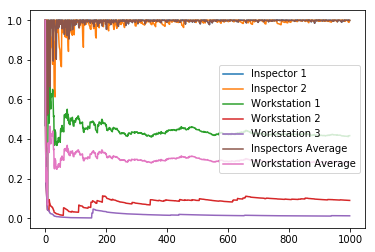

In [16]:
ov_ef.plot()

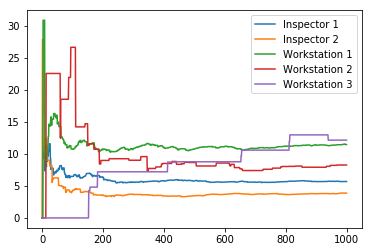

In [17]:
prod_rate.plot()

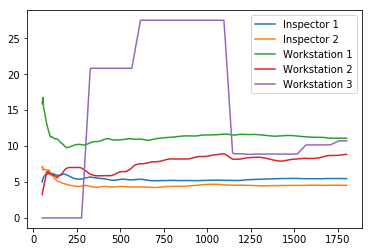

In [136]:
move.plot()